In [1]:
# =============================================================================
# 1. IMPORTS & CONFIGURATION
# =============================================================================
import os
import pickle
import re
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Evaluation metrics
import nltk
from rouge_score import rouge_scorer

# Gradio for App
import gradio as gr

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# Configuration
BATCH_SIZE = 128
EMBED_DIM = 256
HIDDEN_SIZE = 512
EPOCHS = 20
LR = 2e-4
MAX_LEN = 30  # Maximum caption length

# Special Tokens
PAD_TOKEN = "<pad>"
UNK_TOKEN = "<unk>"
START_TOKEN = "<start>"
END_TOKEN = "<end>"
SPECIALS = [PAD_TOKEN, UNK_TOKEN, START_TOKEN, END_TOKEN]

Running on device: cuda


In [3]:
# =============================================================================
# 2. DATA LOCATION & FEATURE EXTRACTION
# =============================================================================
def find_image_dir():
    """Locates the Flickr30k image directory within Kaggle input."""
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        if len([f for f in files if f.endswith('.jpg')]) > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
if not IMAGE_DIR:
    raise FileNotFoundError("Flickr30k dataset not found. Please add it to the notebook.")

CAPTIONS_PATH = "/kaggle/input/datasets/adityajn105/flickr30k/captions.txt"
FEATURES_FILE = 'flickr30k_features.pkl'

# Preprocessing transforms for ResNet
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def extract_features_if_needed():
    """Extracts image features using ResNet50 if the pickle file doesn't exist."""
    if os.path.exists(FEATURES_FILE):
        print(f"Loading features from {FEATURES_FILE}...")
        with open(FEATURES_FILE, 'rb') as f:
            return pickle.load(f)

    print("Feature file not found. Extracting features with ResNet50...")
    
    # Load ResNet50 (headless)
    resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove classification layer
    resnet = nn.DataParallel(resnet).to(device)
    resnet.eval()

    # Simple dataset for extraction
    class ImageDataset(Dataset):
        def __init__(self, img_dir, transform):
            self.img_names = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
            self.img_dir = img_dir
            self.transform = transform
        def __len__(self): return len(self.img_names)
        def __getitem__(self, idx):
            name = self.img_names[idx]
            img = Image.open(os.path.join(self.img_dir, name)).convert('RGB')
            return self.transform(img), name

    dataset = ImageDataset(IMAGE_DIR, resnet_transform)
    loader = DataLoader(dataset, batch_size=128, num_workers=2)
    
    feats_dict = {}
    with torch.no_grad():
        for imgs, names in tqdm(loader, desc="Extracting Features"):
            # Output shape: (B, 2048, 1, 1) -> Flatten to (B, 2048)
            output = resnet(imgs.to(device)).view(imgs.size(0), -1)
            for i, name in enumerate(names):
                feats_dict[name] = output[i].cpu().numpy()

    with open(FEATURES_FILE, 'wb') as f:
        pickle.dump(feats_dict, f)
    
    print(f"Saved features for {len(feats_dict)} images.")
    return feats_dict

# Load features into memory
image_features = extract_features_if_needed()

Feature file not found. Extracting features with ResNet50...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s] 
Extracting Features: 100%|██████████| 249/249 [02:44<00:00,  1.51it/s]


Saved features for 31783 images.


In [4]:
# =============================================================================
# 3. TEXT PREPROCESSING & VOCABULARY
# =============================================================================
def clean_caption(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Load and clean captions
rows = []
with open(CAPTIONS_PATH, "r", encoding="utf-8") as f:
    next(f)  # Skip header
    for line in f:
        line = line.strip()
        if not line: continue
        # Handle varying delimiters
        parts = line.split("\t" if "\t" in line else ",", 1)
        if len(parts) == 2:
            rows.append((parts[0].strip(), clean_caption(parts[1])))

df = pd.DataFrame(rows, columns=["image", "caption"])

# Build Vocabulary
counter = Counter()
for cap in df["caption"]:
    counter.update(cap.split())

min_freq = 3
vocab_words = [w for w, c in counter.items() if c >= min_freq]
vocab = SPECIALS + sorted(vocab_words)

word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

PAD_ID = word2idx[PAD_TOKEN]
UNK_ID = word2idx[UNK_TOKEN]
START_ID = word2idx[START_TOKEN]
END_ID = word2idx[END_TOKEN]
VOCAB_SIZE = len(vocab)

print(f"Vocabulary Size: {VOCAB_SIZE}")

# Encode Captions
def encode_caption(text):
    tokens = text.split()
    return [START_ID] + [word2idx.get(t, UNK_ID) for t in tokens] + [END_ID]

def pad_caption(ids, max_len=MAX_LEN):
    ids = ids[:max_len]
    return ids + [PAD_ID] * (max_len - len(ids)) if len(ids) < max_len else ids

df["cap_ids"] = df["caption"].apply(encode_caption)
df["cap_ids_pad"] = df["cap_ids"].apply(lambda x: pad_caption(x))

# Train/Val/Test Split (Grouped by Image to prevent leakage)
unique_images = df["image"].unique()
train_imgs, test_imgs = train_test_split(unique_images, test_size=0.1, random_state=42)
train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.1, random_state=42)

train_df = df[df["image"].isin(train_imgs)].reset_index(drop=True)
val_df = df[df["image"].isin(val_imgs)].reset_index(drop=True)
test_df = df[df["image"].isin(test_imgs)].reset_index(drop=True)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Vocabulary Size: 10029
Train: 128715, Val: 14305, Test: 15895


In [7]:
# =============================================================================
# 4. DATASET & MODEL ARCHITECTURE
# =============================================================================
class CaptionDataset(Dataset):
    def __init__(self, dataframe, features):
        self.df = dataframe
        self.features = features

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row["image"]
        caption_seq = torch.tensor(row["cap_ids_pad"], dtype=torch.long)
        
        # Teacher forcing: Input is seq[:-1], Target is seq[1:]
        cap_input = caption_seq[:-1]
        cap_target = caption_seq[1:]
        
        img_feat = torch.tensor(self.features[img_name], dtype=torch.float32)
        return img_feat, cap_input, cap_target

train_loader = DataLoader(CaptionDataset(train_df, image_features), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(CaptionDataset(val_df, image_features), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(CaptionDataset(test_df, image_features), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class Encoder(nn.Module):
    def __init__(self, hidden_size=HIDDEN_SIZE):
        super().__init__()
        self.fc = nn.Linear(2048, hidden_size)
        self.dropout = nn.Dropout(0.3)
        self.activation = nn.Tanh()

    def forward(self, img_feat):
        # Project 2048 -> Hidden Size
        x = self.dropout(self.activation(self.fc(img_feat)))
        return x.unsqueeze(0)  # Reshape to (1, Batch, Hidden) for LSTM

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=EMBED_DIM, hidden_size=HIDDEN_SIZE):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_ID)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, cap_input, hidden_state):
        # cap_input: (Batch, Seq_Len)
        embeddings = self.dropout(self.embed(cap_input))
        
        # Initialize LSTM with encoder output (hidden state) and zero cell state
        if isinstance(hidden_state, tuple):
             h_0, c_0 = hidden_state
        else:
             h_0 = hidden_state
             c_0 = torch.zeros_like(h_0)
             
        output, (h_n, c_n) = self.lstm(embeddings, (h_0, c_0))
        logits = self.fc(output)
        return logits, (h_n, c_n)

class Seq2Seq(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(vocab_size)

    def forward(self, img_feat, cap_input):
        hidden = self.encoder(img_feat)
        logits, _ = self.decoder(cap_input, hidden)
        return logits

model = Seq2Seq(VOCAB_SIZE).to(device)

Starting Training...


Epoch 1/20 | Train Loss: 4.6427 | Val Loss: 4.0751
Model saved.


Epoch 2/20 | Train Loss: 3.8969 | Val Loss: 3.7022
Model saved.


Epoch 3/20 | Train Loss: 3.5881 | Val Loss: 3.4842
Model saved.


Epoch 4/20 | Train Loss: 3.3947 | Val Loss: 3.3559
Model saved.


Epoch 5/20 | Train Loss: 3.2633 | Val Loss: 3.2710
Model saved.


Epoch 6/20 | Train Loss: 3.1639 | Val Loss: 3.2107
Model saved.


Epoch 7/20 | Train Loss: 3.0845 | Val Loss: 3.1601
Model saved.


Epoch 8/20 | Train Loss: 3.0177 | Val Loss: 3.1231
Model saved.


Epoch 9/20 | Train Loss: 2.9613 | Val Loss: 3.0940
Model saved.


Epoch 10/20 | Train Loss: 2.9127 | Val Loss: 3.0711
Model saved.


Epoch 11/20 | Train Loss: 2.8696 | Val Loss: 3.0511
Model saved.


Epoch 12/20 | Train Loss: 2.8310 | Val Loss: 3.0347
Model saved.


Epoch 13/20 | Train Loss: 2.7954 | Val Loss: 3.0188
Model saved.


Epoch 14/20 | Train Loss: 2.7635 | Val Loss: 3.0073
Model saved.


Epoch 15/20 | Train Loss: 2.7337 | Val Loss: 2.9992
Model saved.


Epoch 16/20 | Train Loss: 2.7065 | Val Loss: 2.9904
Model saved.


Epoch 17/20 | Train Loss: 2.6802 | Val Loss: 2.9820
Model saved.


Epoch 18/20 | Train Loss: 2.6567 | Val Loss: 2.9758
Model saved.


Epoch 19/20 | Train Loss: 2.6334 | Val Loss: 2.9715
Model saved.


Epoch 20/20 | Train Loss: 2.6123 | Val Loss: 2.9652
Model saved.


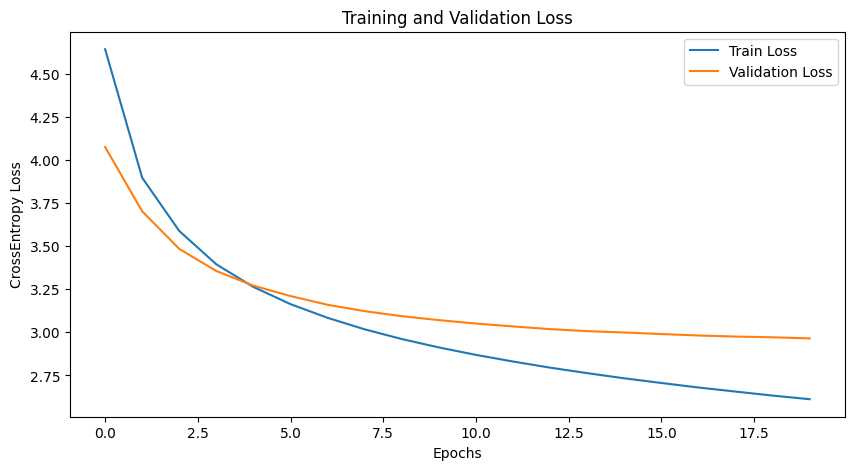

<All keys matched successfully>

In [6]:
# =============================================================================
# 5. TRAINING LOOP
# =============================================================================
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def train_epoch(loader):
    model.train()
    total_loss = 0
    for img_feat, cap_in, cap_out in tqdm(loader, leave=False, desc="Training"):
        img_feat, cap_in, cap_out = img_feat.to(device), cap_in.to(device), cap_out.to(device)
        
        optimizer.zero_grad()
        logits = model(img_feat, cap_in)
        
        # Reshape for loss: (Batch * Seq_Len, Vocab_Size)
        loss = criterion(logits.reshape(-1, VOCAB_SIZE), cap_out.reshape(-1))
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

def val_epoch(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for img_feat, cap_in, cap_out in tqdm(loader, leave=False, desc="Validation"):
            img_feat, cap_in, cap_out = img_feat.to(device), cap_in.to(device), cap_out.to(device)
            logits = model(img_feat, cap_in)
            loss = criterion(logits.reshape(-1, VOCAB_SIZE), cap_out.reshape(-1))
            total_loss += loss.item()
    return total_loss / len(loader)

train_losses, val_losses = [], []
best_val_loss = float('inf')
patience_counter = 0
EARLY_STOP = 6

print("Starting Training...")
for epoch in range(1, EPOCHS + 1):
    train_loss = train_epoch(train_loader)
    val_loss = val_epoch(val_loader)
    
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("Model saved.")
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP:
            print("Early stopping triggered.")
            break

# Plot Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("CrossEntropy Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Load best model for inference
model.load_state_dict(torch.load("best_model.pt"))

In [8]:
# =============================================================================
# 6. INFERENCE & METRICS EVALUATION
# =============================================================================
@torch.no_grad()
def beam_search(img_feat_tensor, beam_width=3, max_len=MAX_LEN):
    model.eval()
    # Initial hidden state
    h = model.encoder(img_feat_tensor.unsqueeze(0).to(device)) # (1, 1, H)
    c = torch.zeros_like(h)
    
    # (sequence, score, hidden, cell)
    beams = [([START_ID], 0.0, h, c)]
    
    for _ in range(max_len):
        new_beams = []
        for seq, score, h_curr, c_curr in beams:
            if seq[-1] == END_ID:
                new_beams.append((seq, score, h_curr, c_curr))
                continue
            
            # Input is the last token generated
            inp = torch.tensor([[seq[-1]]], device=device)
            embed = model.decoder.dropout(model.decoder.embed(inp))
            
            # LSTM step
            out, (h_next, c_next) = model.decoder.lstm(embed, (h_curr, c_curr))
            logits = model.decoder.fc(out) # (1, 1, Vocab)
            log_probs = torch.log_softmax(logits[0, 0], dim=0)
            
            # Top-K
            topk_log_probs, topk_ids = torch.topk(log_probs, beam_width)
            
            for k in range(beam_width):
                next_id = topk_ids[k].item()
                next_score = score + topk_log_probs[k].item()
                new_beams.append((seq + [next_id], next_score, h_next, c_next))
        
        # Sort by score (descending) and keep top beam_width
        beams = sorted(new_beams, key=lambda x: x[1], reverse=True)[:beam_width]
        
        # If all beams ended, stop
        if all(b[0][-1] == END_ID for b in beams):
            break

    best_seq = beams[0][0]
    tokens = [idx2word.get(i, UNK_TOKEN) for i in best_seq if i not in {START_ID, END_ID, PAD_ID}]
    return " ".join(tokens)

def compute_metrics(test_df, features_dict, sample_size=500):
    """Computes BLEU-4, ROUGE, Precision, Recall, and F1."""
    print(f"\nEvaluating on {sample_size} random test images...")
    
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    chen_cherry = SmoothingFunction()
    
    bleu_scores = []
    rouge1_f1, rougeL_f1 = [], []
    precision_list, recall_list = [], []

    # Sample a subset for faster evaluation
    test_subset = test_df["image"].drop_duplicates().sample(n=min(len(test_df), sample_size), random_state=42)
    
    for img_name in tqdm(test_subset, desc="Computing Metrics"):
        # Ground Truths (List of strings)
        ground_truths = test_df[test_df["image"] == img_name]["caption"].tolist()
        
        # Prediction
        feat = torch.tensor(features_dict[img_name], dtype=torch.float32)
        prediction = beam_search(feat, beam_width=3)
        
        # 1. BLEU-4
        ref_tokens = [t.split() for t in ground_truths]
        pred_tokens = prediction.split()
        bleu = sentence_bleu(ref_tokens, pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chen_cherry.method1)
        bleu_scores.append(bleu)
        
        # 2. ROUGE (Take max score among references)
        best_r1, best_rl = 0.0, 0.0
        best_prec, best_rec = 0.0, 0.0
        
        for gt in ground_truths:
            scores = rouge.score(gt, prediction)
            
            # ROUGE-1
            if scores['rouge1'].fmeasure > best_r1:
                best_r1 = scores['rouge1'].fmeasure
                best_prec = scores['rouge1'].precision
                best_rec = scores['rouge1'].recall
            
            # ROUGE-L
            if scores['rougeL'].fmeasure > best_rl:
                best_rl = scores['rougeL'].fmeasure
                
        rouge1_f1.append(best_r1)
        rougeL_f1.append(best_rl)
        precision_list.append(best_prec)
        recall_list.append(best_rec)

    metrics = {
        "BLEU-4": np.mean(bleu_scores),
        "ROUGE-1 F1": np.mean(rouge1_f1),
        "ROUGE-L F1": np.mean(rougeL_f1),
        "Precision": np.mean(precision_list),
        "Recall": np.mean(recall_list)
    }
    
    print("\n" + "="*30)
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    print("="*30)
    return metrics

# Run Evaluation
compute_metrics(test_df, image_features)


Evaluating on 500 random test images...


Computing Metrics: 100%|██████████| 500/500 [00:33<00:00, 14.98it/s]


BLEU-4: 0.0003
ROUGE-1 F1: 0.0096
ROUGE-L F1: 0.0096
Precision: 0.0069
Recall: 0.0177


{'BLEU-4': np.float64(0.00031955734076239626),
 'ROUGE-1 F1': np.float64(0.009581282209882068),
 'ROUGE-L F1': np.float64(0.009581282209882068),
 'Precision': np.float64(0.006933333333333334),
 'Recall': np.float64(0.017677854342215412)}

In [9]:
# =============================================================================
# 7. APP DEPLOYMENT (GRADIO)
# =============================================================================
# Load ResNet for live inference (independent of cached features)
resnet_live = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet_live = nn.Sequential(*list(resnet_live.children())[:-1])
resnet_live = resnet_live.to(device)
resnet_live.eval()

def generate_caption_app(image):
    """
    Inference function for Gradio.
    Takes a PIL image, extracts features, and generates a caption.
    """
    if image is None:
        return "Please upload an image."
    
    try:
        # Preprocess image
        img_tensor = resnet_transform(image).unsqueeze(0).to(device)
        
        # Extract features
        with torch.no_grad():
            feature = resnet_live(img_tensor).view(1, -1) # (1, 2048)
            feature = feature.squeeze(0) # (2048,)
        
        # Generate Caption
        caption = beam_search(feature, beam_width=5)
        return caption.capitalize()
    except Exception as e:
        return f"Error: {str(e)}"

# Define Gradio Interface
interface = gr.Interface(
    fn=generate_caption_app,
    inputs=gr.Image(type="pil", label="Upload Image"),
    outputs=gr.Textbox(label="Generated Caption"),
    title="Neural Storyteller",
    description="Upload an image to generate a descriptive caption using the ResNet50 + Seq2Seq model.",
    examples=[os.path.join(IMAGE_DIR, x) for x in random.sample(os.listdir(IMAGE_DIR), 3)],
    theme="default"
)

# Launch the app
print("Launching Gradio App...")
interface.launch(share=True)

Launching Gradio App...
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://75826a7cbfac074c27.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/routes.py", line 1298, in predict
    output = await route_utils.call_process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1623, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 63, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^^^^^^^^^^^^^

Created dataset file at: .gradio/flagged/dataset1.csv


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/routes.py", line 1298, in predict
    output = await route_utils.call_process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2116, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1623, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/anyio/to_thread.py", line 63, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^^^^^^^^^^^^^